## Boston Housing Price Prediction

In [2]:
import mlflow

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
print("Successfully set MLFlow Server Path")

Successfully set MLFlow Server Path


## Step 1: Load the boston housing dataset

In [1]:
from src.models.boston_house_price_prediction import env
from src.models.boston_house_price_prediction import train_model
import importlib

# Reload the env module to ensure changes are reflected
#importlib.reload(env)  


boston = train_model.load_data(data_dir=env.data_dir)
if boston is not None:
    print("******* Successfully loaded boston data ********")
else:
    print("Boston data is not loaded.")
    raise Exception()

***************** LOAD ENVIRONMENT ********************+
Project Root DIR /home/joesan/Projects/Private/ml-projects/nn-playground
Project Data DIR /home/joesan/Projects/Private/ml-projects/nn-playground/data/raw/boston_housing_price
Models Dump DIR /home/joesan/Projects/Private/ml-projects/nn-playground/models/boston_housing_price
***************** LOAD ENVIRONMENT ********************+
Dataset file: /home/joesan/Projects/Private/ml-projects/nn-playground/data/raw/boston_housing_price/boston_housing.csv
Dataset file exists.
******* Successfully loaded boston data ********


In [10]:
# Let us describe the data
print(boston.describe())

             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.1057

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [11]:
# Extracting features (first 12 columns)
import pandas as pd

# Extracting features (first 12 columns) as a DataFrame
X = boston.iloc[:, :-1]

# Extracting target variable (last column) as a Series
y = boston.iloc[:, -1]

# Print the features and target variable
print(X)
print(y)

        CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0    0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1    0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2    0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3    0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4    0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   
..       ...   ...    ...   ...    ...    ...   ...     ...  ...    ...   
501  0.06263   0.0  11.93     0  0.573  6.593  69.1  2.4786    1  273.0   
502  0.04527   0.0  11.93     0  0.573  6.120  76.7  2.2875    1  273.0   
503  0.06076   0.0  11.93     0  0.573  6.976  91.0  2.1675    1  273.0   
504  0.10959   0.0  11.93     0  0.573  6.794  89.3  2.3889    1  273.0   
505  0.04741   0.0  11.93     0  0.573  6.030  80.8  2.5050    1  273.0   

     PTRATIO       B  LSTAT  
0       15.3  396.90   4.98  
1       17.8  396.90   9.14  
2       1

Text(0, 0.5, 'MEDV')

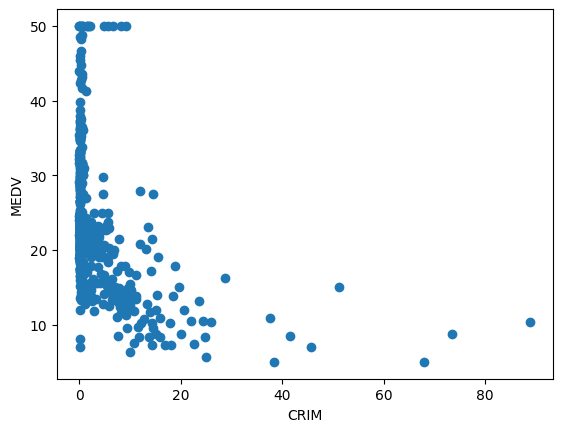

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from pandas.plotting import scatter_matrix


# scatter plot
plt.scatter(boston['CRIM'], boston['MEDV'])
plt.xlabel("CRIM")
plt.ylabel("MEDV")


# Step 1: Basic Data Cleansing

In [2]:
# Delete unique columns & delete duplicate rows
from src.models.boston_house_price_prediction import cleanse_data

boston_delete_unique_columns = cleanse_data.delete_unique_columns(boston)
boston_delete_duplicate_rows = cleanse_data.delete_duplicate_rows(boston_delete_unique_columns)

************+ delete_unique_columns ************+ 
Shape of boston before deleting unique columns (506, 14)
Count of Unique columns: CRIM       504
ZN          26
INDUS       76
CHAS         2
NOX         81
RM         446
AGE        356
DIS        412
RAD          9
TAX         66
PTRATIO     46
B          357
LSTAT      455
MEDV       229
dtype: int64
Shape of boston after deleting unique columns (506, 14)
************+ delete_unique_columns ************+ 
************+ delete_duplicate_rows ************+ 
Are there any duplicates?  False
************+ delete_duplicate_rows ************+ 


In [4]:
# Handling missing data

# Summarize the number of rows with missing values for each column
for column in boston.columns:
    # Count number of rows with missing values
    n_miss = boston[column].isnull().sum()
    perc = n_miss / boston.shape[0] * 100
    print(f' > {column}, Missing: {n_miss} ({perc:.1f}%)')

 > CRIM, Missing: 0 (0.0%)
 > ZN, Missing: 0 (0.0%)
 > INDUS, Missing: 0 (0.0%)
 > CHAS, Missing: 0 (0.0%)
 > NOX, Missing: 0 (0.0%)
 > RM, Missing: 0 (0.0%)
 > AGE, Missing: 0 (0.0%)
 > DIS, Missing: 0 (0.0%)
 > RAD, Missing: 0 (0.0%)
 > TAX, Missing: 0 (0.0%)
 > PTRATIO, Missing: 0 (0.0%)
 > B, Missing: 0 (0.0%)
 > LSTAT, Missing: 0 (0.0%)
 > MEDV, Missing: 0 (0.0%)


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((404, 13), (102, 13), (404,), (102,))

# Step 2: Feature Selection

In [ ]:
# Select features